# **TAURUS dataset**

In [39]:
import os
import harreman
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, ttest_ind, mannwhitneyu
import mplscience
from sklearn.neighbors import NearestNeighbors
from statsmodels.stats.multitest import multipletests
from plotnine import *
import warnings
warnings.filterwarnings("ignore")

BASE_PATH = "/home/projects/nyosef/oier/Harreman_files/Visium_colon"
TAURUS_PATH = os.path.join(BASE_PATH, 'TAURUS')
SPATIAL_ADATA_PATH = os.path.join(BASE_PATH, 'h5ads')
SPATIAL_DATA_PATH = os.path.join(BASE_PATH, 'data')
PLOTS_PATH = os.path.join(BASE_PATH, 'plots')

## Differential expression analysis in the spatial dataset

DE analysis between spots with non-zero score of vitamin A and LPC vs the ones with zero score in the distal part of the day 14 colon

In [7]:
st_adata = harreman.read_h5ad(os.path.join(SPATIAL_ADATA_PATH, 'Visium_colon_Harreman_unrolled.h5ad'))

In [11]:
metabolites = ['Vitamin A', 'Lysophosphatidylcholine']
interacting_cell_scores_m = st_adata.uns['interacting_cell_results']['np']['m']['cs'].copy()
scores = pd.DataFrame(interacting_cell_scores_m, index=st_adata.obs_names, columns=st_adata.uns['metabolites']).replace(np.nan, 0)
metab_scores = scores[metabolites]

In [19]:
day14_distal_modules = ['Module 5', 'Module 6', 'Module 7']
metab_scores_day14_dist = metab_scores[(st_adata.obs['top_super_module'].isin(day14_distal_modules)) & (st_adata.obs['cond'] == 'Day 14')].copy()

In [23]:
metab_inactive = metab_scores_day14_dist.index[metab_scores_day14_dist.sum(axis=1) == 0]
metab_active = metab_scores_day14_dist.index[metab_scores_day14_dist.sum(axis=1) != 0]

In [24]:
st_adata.obs['metab_active'] = np.nan
st_adata.obs['metab_active'][st_adata.obs_names.isin(metab_active)] = 'Yes'
st_adata.obs['metab_active'][st_adata.obs_names.isin(metab_inactive)] = 'No'

In [27]:
st_adata.uns["log1p"] = {}
st_adata.uns["log1p"]["base"] = None

sc.tl.rank_genes_groups(
    st_adata,
    "metab_active",
    groups=['Yes'],
    reference='No',
    method="wilcoxon",
    layer="log_norm",
)

In [28]:
df = sc.get.rank_genes_groups_df(st_adata, group='Yes').set_index('names')

In [45]:
# df.to_csv(f'{SPATIAL_DATA_PATH}/Vitamin_A_LPC_active_vs_inactive_DE_results.csv')

## Load dataset

The data was obtained from https://github.com/ludvigla/healing_intestine_analysis.

In [2]:
adata = sc.read_h5ad(f'{TAURUS_PATH}/TAURUS_raw_counts_annotated_final.h5ad')

In [40]:
UMAP = pd.read_csv(f'{TAURUS_PATH}/UMAP_combined_objects.txt', delimiter='\t', index_col=0)

In [41]:
adata.obsm['X_umap'] = UMAP.to_numpy()

In [43]:
adata.layers['counts'] = adata.X.copy()
norm = sc.pp.normalize_total(adata, target_sum=1e4, inplace=False)
adata.layers["normalized"] = norm["X"]
adata.layers["log_norm"] = sc.pp.log1p(norm["X"], copy=True)

In [49]:
from_ct_to_group = {
    'Plasma_cell': 'Immune',
    'Stroma': 'Stroma',
    'CD4_cytotoxic_lo_T_cell': 'Immune',
    'CD8_cytotoxic_hi_T_cell_NK': 'Immune',
    'Epithelium_non_ileal': 'Epithelium',
    'B_cell': 'Immune',
    'Myeloid': 'Immune',
    'ILC': 'Immune',
    'Epithelium_ileum': 'Epithelium',
}

In [50]:
adata.obs['cell_group'] = adata.obs['bucket'].map(lambda x: from_ct_to_group[x])

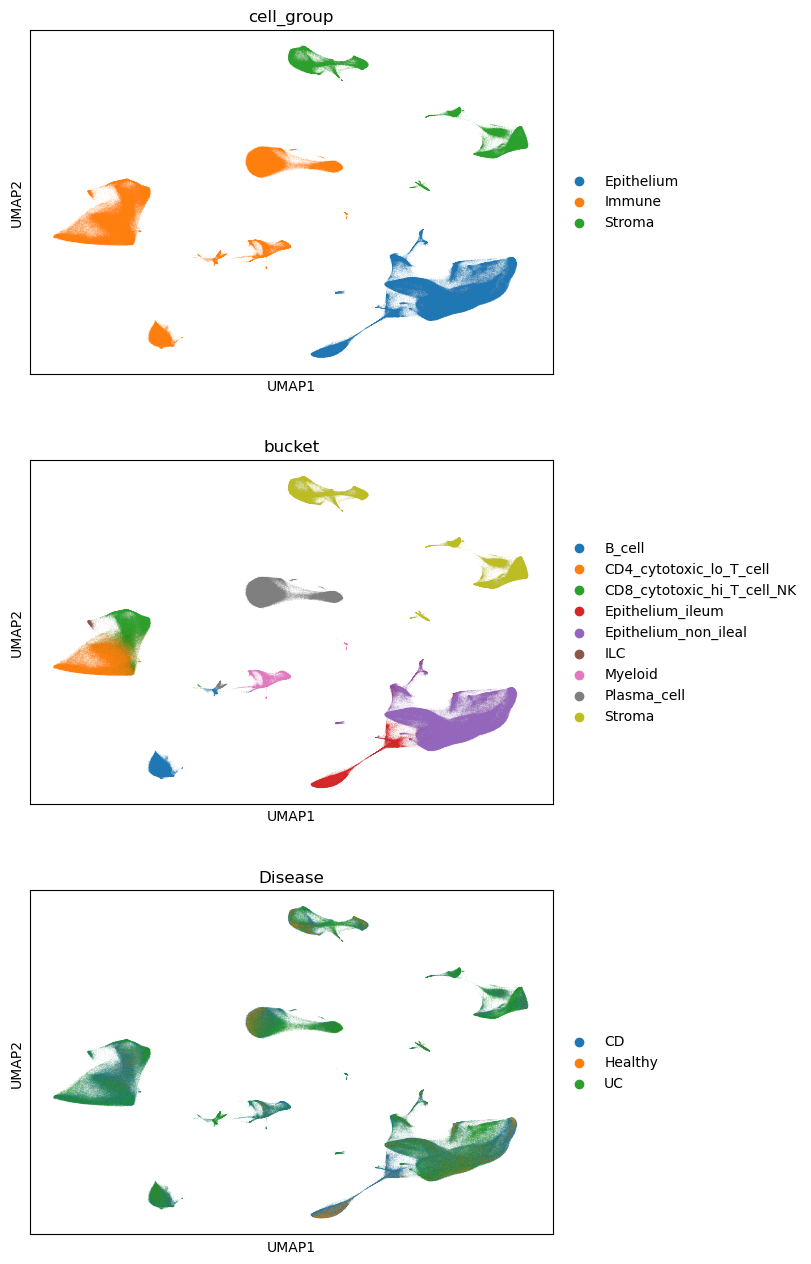

In [52]:
sc.pl.umap(adata, color=['cell_group', 'bucket', 'Disease'], ncols=1)

## Signature analysis

In [53]:
df = pd.read_csv(f'{SPATIAL_DATA_PATH}/Vitamin_A_LPC_active_vs_inactive_DE_results.csv', index_col=0)

In [56]:
top_genes = df[(df['logfoldchanges'] > 0) & (df['pvals_adj'] < 0.05)].sort_values('logfoldchanges', ascending=False)[:200].index.tolist()
sig_dict = {'Vitamin_A_LPC_genes': top_genes}

In [58]:
UC_CD_adata = adata[adata.obs['Disease'] != 'Healthy'].copy()

In [59]:
harreman.vs.signatures_from_file(UC_CD_adata, dicts=[sig_dict])

harreman.vs.analyze_vision(
    adata=UC_CD_adata,
    norm_data_key="log_norm",
    signature_varm_key="signatures",
    scores_only=True,
)

Computing signatures for each cell...
Finished computing signatures for each cell in 3781.607 seconds


In [60]:
# UC_CD_adata.write(f'{TAURUS_PATH}/TAURUS_Vitamin_A_LPC_visionpy_adata.h5ad')

## visionpy downstream analysis

In [2]:
UC_CD_adata = sc.read_h5ad(f'{TAURUS_PATH}/TAURUS_Vitamin_A_LPC_visionpy_adata.h5ad')

In [3]:
UC_CD_adata.obs['Vitamin_A_LPC_genes'] = UC_CD_adata.obsm['vision_signatures']['Vitamin_A_LPC_genes']

In [4]:
variables = ['Vitamin_A_LPC_genes', 'Inflammation_score', 'Disease', 'cell_group']

In [5]:
df = UC_CD_adata.obs[variables].copy()

In [6]:
df['group'] = 'middle'
grouped_dfs = []
for compartment in df['cell_group'].unique():
    for disease in df['Disease'].unique():
        sub_df = df[(df['cell_group'] == compartment) & (df['Disease'] == disease)].copy()
        q_low = sub_df['Vitamin_A_LPC_genes'].quantile(0.2)
        q_high = sub_df['Vitamin_A_LPC_genes'].quantile(0.8)
        sub_df['group'] = 'middle'
        sub_df.loc[sub_df['Vitamin_A_LPC_genes'] <= q_low, 'group'] = 'bottom'
        sub_df.loc[sub_df['Vitamin_A_LPC_genes'] >= q_high, 'group'] = 'top'
        grouped_dfs.append(sub_df)

df_grouped = pd.concat(grouped_dfs)
df_filtered = df_grouped[df_grouped['group'].isin(['top', 'bottom'])]

In [9]:
df_filtered

,Vitamin_A_LPC_genes,Inflammation_score,Disease,cell_group,group
AAACGAACAGCGTTTA-1-CID003352-2,2.352026,7.984232,UC,Immune,top
AAAGGATGTCCAGAAG-1-CID003352-2,-0.785515,7.984232,UC,Immune,bottom
AAAGGATTCGACCATA-1-CID003352-2,2.445332,7.984232,UC,Immune,top
AAAGGGCTCACCGCTT-1-CID003352-2,-1.107882,7.984232,UC,Immune,bottom
AAAGGGCTCGGAGTAG-1-CID003352-2,-0.230243,7.984232,UC,Immune,bottom
...,...,...,...,...,...
TTTGACTGTCATTGCA-1-CID006576-1,7.099483,7.518272,CD,Epithelium,top
TTTGACTTCTTAGTTC-1-CID006576-1,4.707413,7.518272,CD,Epithelium,top
TTTGATCTCCAAGCAT-1-CID006576-1,1.065177,7.518272,CD,Epithelium,bottom
TTTGGAGTCTATACGG-1-CID006576-1,4.480153,7.518272,CD,Epithelium,top


In [41]:
def run_de_wilcoxon(subdf):
    top = subdf.loc[subdf["group"] == "top", "Inflammation_score"]
    bottom = subdf.loc[subdf["group"] == "bottom", "Inflammation_score"]

    if len(top) > 1 and len(bottom) > 1:
        stat, p_val = mannwhitneyu(top, bottom, alternative="two-sided")
    else:
        stat, p_val = None, None

    return pd.Series({
        "n_top": len(top),
        "n_bottom": len(bottom),
        "mean_top": top.mean(),
        "mean_bottom": bottom.mean(),
        "median_top": top.median(),
        "median_bottom": bottom.median(),
        "effect_size": top.median() - bottom.median(),
        "statistic": stat,
        "p_value": p_val
    })

de_results = (
    df_filtered.groupby(["Disease", "cell_group"])
    .apply(run_de_wilcoxon)
    .reset_index()
)

de_results["p_adj"] = multipletests(de_results["p_value"], method="fdr_bh")[1]

df_merged = df_filtered.merge(de_results[["Disease", "cell_group", "p_adj"]], on=["Disease", "cell_group"], how="left")

def sig_stars(p):
    if pd.isnull(p): return ""
    elif p < 0.001: return "***"
    elif p < 0.01: return "**"
    elif p < 0.05: return "*"
    else: return "ns"

df_merged["stars"] = df_merged["p_adj"].apply(sig_stars)

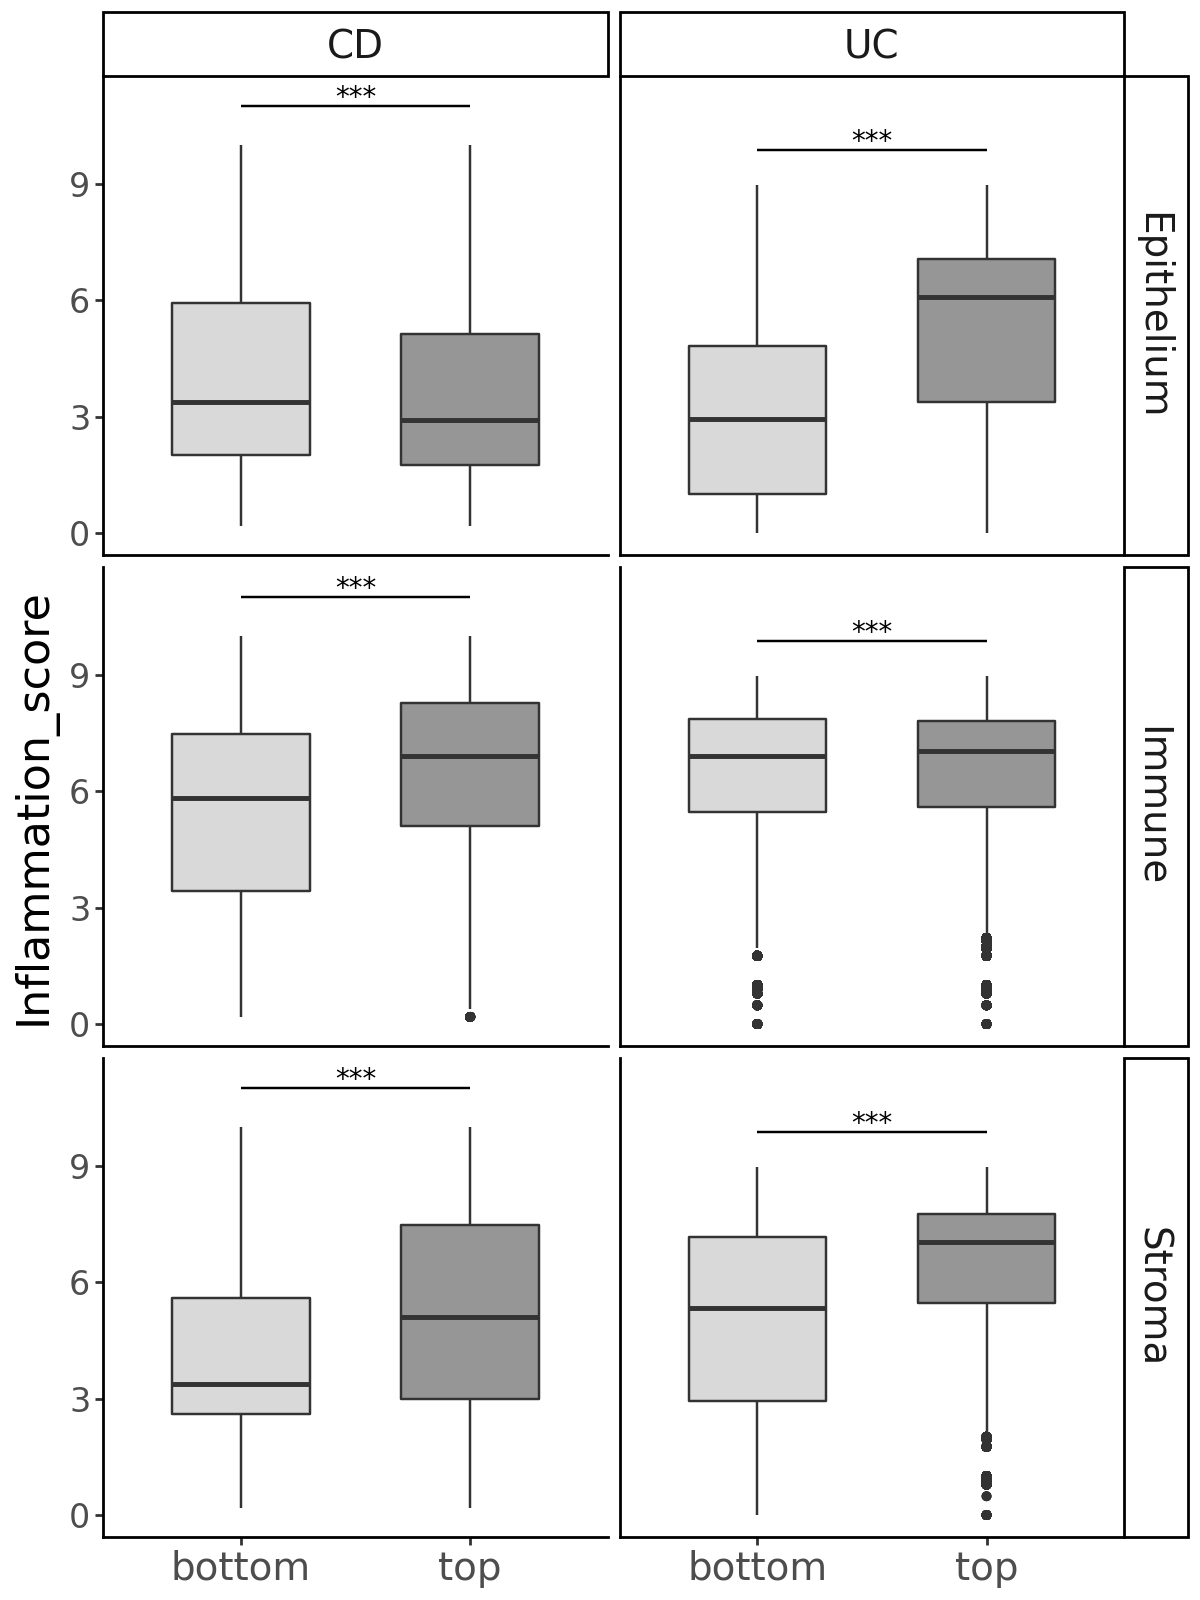

In [43]:
# Compute y positions for annotations
y_offsets = (
    df_merged.groupby(["Disease", "cell_group"])["Inflammation_score"]
    .max()
    .reset_index(name="y_pos")
)
y_offsets["y_pos"] = y_offsets["y_pos"] * 1.1  # lift line above boxes

# Prepare per-facet annotation DataFrame
anno_df = (
    y_offsets.merge(de_results[["Disease", "cell_group", "p_adj"]], on=["Disease", "cell_group"], how="left")
)
anno_df["stars"] = anno_df["p_adj"].apply(sig_stars)
anno_df["x_start"] = 1
anno_df["x_end"] = 2
anno_df["x_text"] = 1.5
anno_df["y_text"] = anno_df["y_pos"] * 1.02

# Base plot
p = (
    ggplot(df_merged, aes(x="group", y="Inflammation_score", fill="group"))
    + geom_boxplot(width=0.6, outlier_size=1)
    + facet_grid("cell_group ~ Disease", scales="free_y", space="free")
    + scale_fill_manual(values={"bottom": "#D9D9D9", "top": "#969696"})
    + theme_classic()
    + theme(
        axis_title_x=element_blank(),
        axis_text_x=element_text(size=14),
        axis_text_y=element_text(size=12),
        axis_title_y=element_text(size=16),
        strip_text=element_text(size=14),
        legend_position="none",
        figure_size=(6, 8)
    )
    # horizontal lines
    + geom_segment(
        aes(x="x_start", xend="x_end", y="y_pos", yend="y_pos"),
        data=anno_df,
        inherit_aes=False
    )
    # stars
    + geom_text(
        aes(x="x_text", y="y_text", label="stars"),
        data=anno_df,
        inherit_aes=False,
        size=10
    )
)
p.show()
p.save(os.path.join(PLOTS_PATH, 'TAURUS_Vitamin_A_LPC_sig_box_plot.svg'), format='svg')